## Importing modules and functions
         
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip

from stats import *

from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Load data

In [2]:
# Set file path
file = 'train_set_curated.sdf'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules (it happens in some datasets, not this one)
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf.shape)

Original data:  (955, 5)
Kept data:  (955, 5)


In [3]:
#convert the activity column to float type
moldf['activity'] = moldf['activity'].astype('float')
print(moldf.dtypes)
moldf.head(1)

activity    float64
InChiKey     object
ID           object
SMILES       object
Mol          object
dtype: object


,activity,InChiKey,ID,SMILES,Mol
0,14.85,CEJLBZWIKQJOAT-UHFFFAOYSA-N,,O=c1[nH]c(=O)n(Cl)c(=O)n1Cl,<rdkit.Chem.rdchem.Mol object at 0x7fa68a9b8c10>


## Data distribution

<AxesSubplot:xlabel='activity', ylabel='activity'>

([<matplotlib.axis.XTick at 0x7fa68dc084f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

([<matplotlib.axis.YTick at 0x7fa68dc194c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

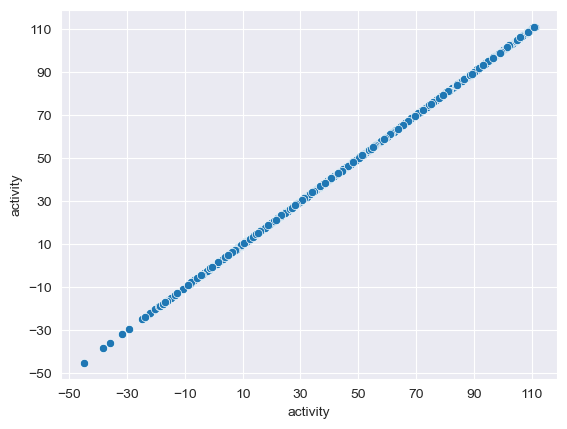

In [4]:
sns.scatterplot(data = moldf, x='activity', y='activity')

plt.xticks(np.arange(-50, 120, 20))  # x-axis labels every 10 units
plt.yticks(np.arange(-50, 120, 20))  # y-axis labels every 10 units

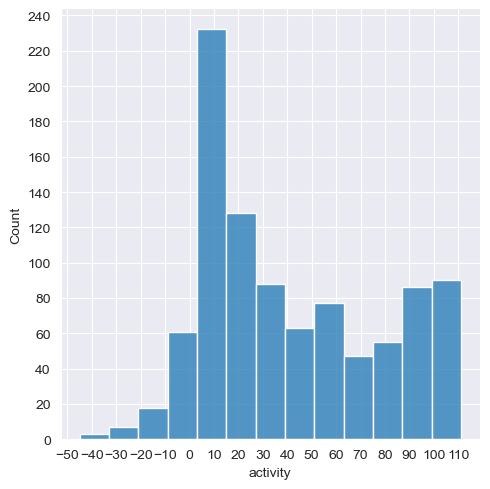

In [5]:
sns.displot(data=moldf, x='activity')
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.show()

<AxesSubplot:ylabel='activity'>

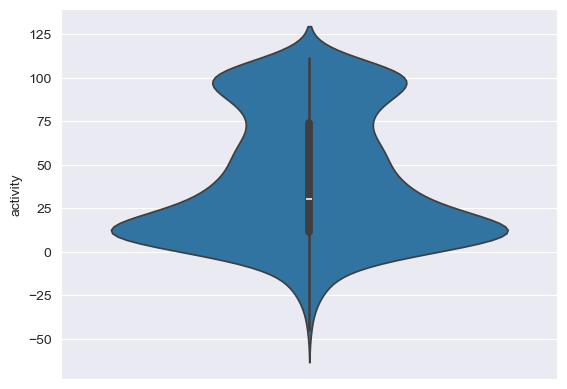

In [6]:
sns.violinplot(data=moldf, y='activity')
plt.show()

# Calculate Morgan Fingerprints

In [7]:
def calcfp(mol,funcFPInfo=dict(radius=2, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Training set
desc = moldf.Mol.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.shape
desc.head(5)


[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerat

(955, 2048)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_train = moldf['activity'].to_numpy()
X_train = desc
X_train.shape

(955, 2048)

## Model building

### Modeling data

#### Finding the best parameters using GridSearch and fitting the model
###### The metric used to find the model parameters giving the best_score for the training set is R2 - it can be changed to RMSE if needed

In [9]:
%%time
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['squared_error', 'absolute_error']
random_state = [33]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion,
              'random_state': random_state}

# setup model building
rf = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1, cv=5, scoring='r2', verbose=1)
rf.fit(X_train, y_train)
print()
print('Best params: %s' % rf.best_params_)
print('Score: %.2f' % rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'criterion': 'absolute_error', 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 33}
Score: 0.40
CPU times: user 1min 50s, sys: 1.03 s, total: 1min 51s
Wall time: 6min 50s


##### Model with best parameters

In [10]:
rf_best = RandomForestRegressor(**rf.best_params_, n_jobs=-1)
rf_best.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=1000, n_jobs=-1, random_state=33)

##### 5-fold cross-validation

In [11]:
from sklearn.model_selection import KFold

# Params
pred = []
index = []

# Initialize storage for metrics per fold
metrics_per_fold = []

# Define the cross-validation parameters
cross_val = KFold(n_splits=5)

# Do 5-fold loop
for train_index, test_index in cross_val.split(X_train):
    # Train the model on the training set
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    
    # Predict on the test set
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    
    # Calculate and store metrics for the current fold
    fold_metrics = regression_stats(y_train[test_index], fold_pred)
    metrics_per_fold.append(fold_metrics)
    
    # Store predictions and additional data
    pred.append(fold_pred)
    index.append(test_index)
    
# Print the metrics for each fold
for fold_idx, fold_metrics in enumerate(metrics_per_fold):
    print(f"Fold {fold_idx + 1} metrics:")
    print(fold_metrics)
    

Fold 1 metrics:
   Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0                      20.97                    732.67   

   Root Mean Squared Error (RMSE)  R-squared (R2)  
0                           27.07            0.46  
Fold 2 metrics:
   Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0                      24.14                    880.37   

   Root Mean Squared Error (RMSE)  R-squared (R2)  
0                           29.67            0.38  
Fold 3 metrics:
   Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0                      22.34                    802.98   

   Root Mean Squared Error (RMSE)  R-squared (R2)  
0                           28.34            0.35  
Fold 4 metrics:
   Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0                      21.52                    750.71   

   Root Mean Squared Error (RMSE)  R-squared (R2)  
0                            27.4            0.37  
Fold 5 metrics:
   Mean Absolute Error (MAE)  Mean S

<Figure size 800x800 with 0 Axes>

Text(0.5, 0, 'Experimental (True) Values')

Text(0, 0.5, 'Predicted Values')

Text(0.5, 1.0, 'Experimental vs. Predicted Percentage of Inhibition after 5-fold external cross validation')

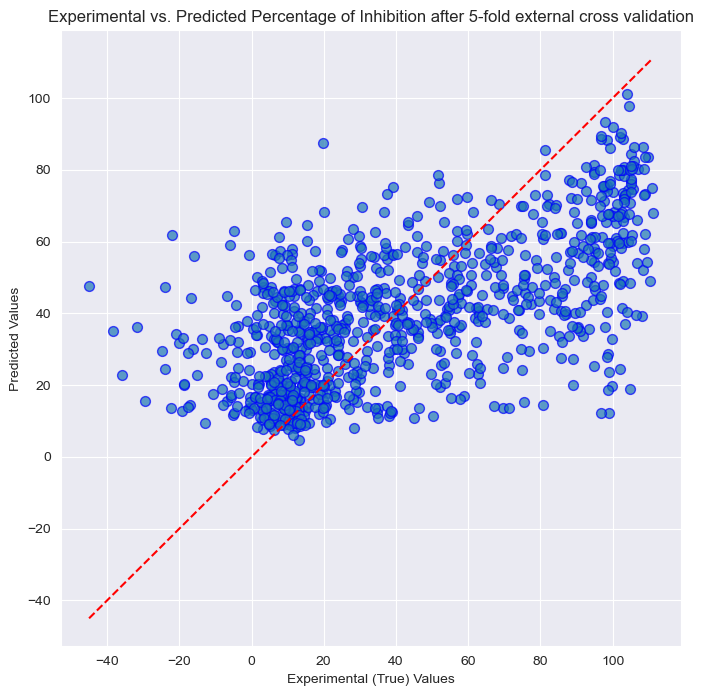

In [12]:
# Concatenate the predicted values and the corresponding true values
all_pred = np.concatenate(pred)
all_true = np.concatenate([y_train[idx] for idx in index])

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_true, all_pred, alpha=0.7, edgecolor='b', s=50)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color='red', linestyle='--')  # Diagonal line

# Add labels and title
plt.xlabel('Experimental (True) Values')
plt.ylabel('Predicted Values')
plt.title('Experimental vs. Predicted Percentage of Inhibition after 5-fold external cross validation')

# Display the plot
plt.show()


In [13]:
# Prepare 5-fold external cross validation results 
fold_index = np.concatenate(index)
fold_pred = np.concatenate(pred)

five_fold_morgan = pd.DataFrame({'Prediction': fold_pred}, index=list(fold_index))
five_fold_morgan.sort_index(inplace=True)
five_fold_morgan['y_train'] = pd.DataFrame(y_train)

# Morgan fp/Random Forest stats
morgan_5f_stats = pd.DataFrame(regression_stats(five_fold_morgan['y_train'], five_fold_morgan['Prediction']))

# Print stats
print('\033[1m' + 'Statistical Characteristics of QSAR model after 5-fold External Cross Validation ' + '\n' + '\033[0m')
morgan_5f_stats

Statistical Characteristics of QSAR model after 5-fold External Cross Validation 



,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R2)
0,22.33,791.52,28.13,0.4


### Predict external set (Leaderboard Set)

##### Load external leaderboard set

In [14]:
# Set file path
file = 'leaderboard_set_curated.sdf'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf_ext = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf_ext.shape)
# Rename ROMol
moldf_ext = moldf_ext.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules (it happens in some datasets, not this one)
moldf_ext = moldf_ext[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf_ext = moldf_ext.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf_ext.shape)


Original data:  (183, 5)
Kept data:  (183, 5)


In [15]:
# Calculate Morgan fingerprints for the external leaderboard set
desc_ext = moldf_ext.Mol.apply(calcfp)
descriptors_ext = desc.columns.difference(moldf_ext.columns).tolist()
desc_ext.shape
desc_ext.head(5)




[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerator
[15:05:22] DEPRECATION WARNING: please use MorganGenerat

(183, 2048)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
# Make predictions
y_ext = moldf_ext['activity'].to_numpy()
X_ext = desc_ext

ext_set_morgan = rf_best.predict(X_ext)

# Prepare data
ext_set_morgan = pd.DataFrame({'Prediction': ext_set_morgan})
ext_set_morgan.sort_index(inplace=True)
ext_set_morgan['y_ext'] = pd.DataFrame(y_ext)


In [17]:
# ext_set Morgan stats
ext_set_morgan_stats = pd.DataFrame(regression_stats(ext_set_morgan['y_ext'], ext_set_morgan['Prediction']))

# Print stats
print('\033[1m' + 'Statistical Characteristics of the Predictions for the External Leaderboard Set by the morgan_rf Model' + '\n' + '\033[0m')
ext_set_morgan_stats

Statistical Characteristics of the Predictions for the External Leaderboard Set by the morgan_rf Model



,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R-squared (R2)
0,20.29,677.3,26.03,0.4


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Experimental (True) Values')

Text(0, 0.5, 'Predicted Values')

Text(0.5, 1.0, 'Experimental vs. Predicted Percentage of Inhibition for the External Leaderboard Set')

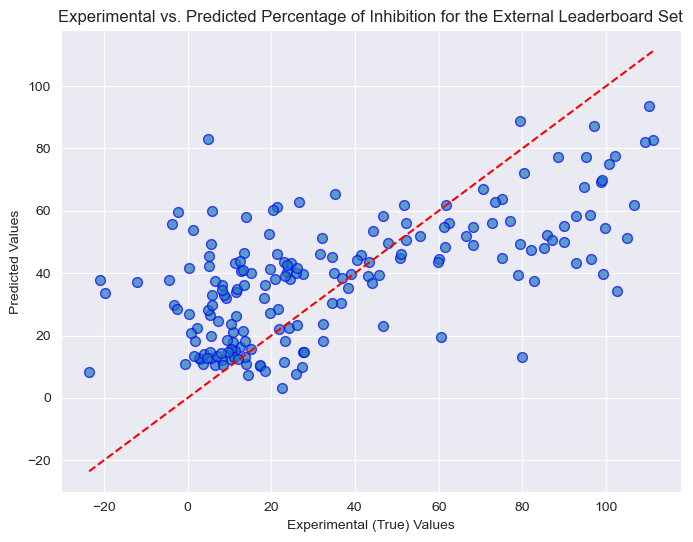

In [18]:
true_ext = pd.to_numeric(ext_set_morgan['y_ext'], errors='coerce')
pred_ext = pd.to_numeric(ext_set_morgan['Prediction'], errors='coerce')

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_ext, pred_ext, alpha=0.7, edgecolor='b', s=50)

# Add a diagonal line to represent a perfect fit
min_val = min(true_ext.min(), pred_ext.min())
max_val = max(true_ext.max(), pred_ext.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labeling the axes
plt.xlabel('Experimental (True) Values')
plt.ylabel('Predicted Values')
plt.title('Experimental vs. Predicted Percentage of Inhibition for the External Leaderboard Set')
plt.grid(True)
plt.show()
  

##### Save model

In [19]:
with gzip.GzipFile('model_train_set_morgan-rf.pgz', 'w') as f:
    cPickle.dump(rf_best, f)